In [4]:
from ipfml.processing.segmentation import divide_in_blocks
from ipfml.processing import transform
from ipfml.filters import convolution as conv
from ipfml.filters import kernels
from ipfml import utils

from PIL import Image
from scipy import signal
from skimage import color
import scipy.stats as stats
import seaborn as sns
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import svd
import os

In [5]:
data_folder = "../dataset"

# Data augmentation analysis

## Utils functions definition

In [6]:
def compute_images_path(dict_data):
    
    scene = dict_data['name']
    prefix = dict_data['prefix']
    indices = dict_data['indices']
    
    images_path = []
    for index in indices:
        path = os.path.join(data_folder, os.path.join(scene, prefix + index + ".png"))
        print(path)
        images_path.append(path)
    return images_path

In [7]:
def get_images_zones(dict_data, images_path):
    
    id_zone = dict_data['zone']
    
    zones_img = []
    for path in images_path:
        img = Image.open(path)
        zones = divide_in_blocks(img, (200, 200))
        zones_img.append(zones[id_zone])
        
    return zones_img

## Scenes information data

In [8]:
# start 00020 - ref 00900 - step 10
dict_appart = {'name': 'Appart1opt02', 
               'prefix': 'appartAopt_', 
               'indices': ["00050", "00100", "00200", "00300", "00400", "00500", "00700", "00900"],
               'zone': 9}

# start 00050 - ref 01200 - step 10
dict_cuisine = {'name': 'Cuisine01', 
               'prefix': 'cuisine01_', 
               'indices': ["00050", "00100", "00200", "00300", "00400", "00600", "00700","00900", "01200"],
               'zone': 6}

# start 00020 - ref 00950 - step 10
dict_sdb_c = {'name': 'SdbCentre', 
               'prefix': 'SdB2_', 
               'indices': ["00020", "00400", "00950"],
               'zone': 3}

# start 00020 - ref 00950 - step 10
dict_sdb_d = {'name': 'SdbDroite', 
               'prefix': 'SdB2_D_', 
               'indices': ["00020", "00400", "00950"],
               'zone': 3}

### Definition of parameters

In [9]:
images_path_appart = compute_images_path(dict_appart)
images_path_cuisine = compute_images_path(dict_cuisine)

../dataset/Appart1opt02/appartAopt_00050.png
../dataset/Appart1opt02/appartAopt_00100.png
../dataset/Appart1opt02/appartAopt_00200.png
../dataset/Appart1opt02/appartAopt_00300.png
../dataset/Appart1opt02/appartAopt_00400.png
../dataset/Appart1opt02/appartAopt_00500.png
../dataset/Appart1opt02/appartAopt_00700.png
../dataset/Appart1opt02/appartAopt_00900.png
../dataset/Cuisine01/cuisine01_00050.png
../dataset/Cuisine01/cuisine01_00100.png
../dataset/Cuisine01/cuisine01_00200.png
../dataset/Cuisine01/cuisine01_00300.png
../dataset/Cuisine01/cuisine01_00400.png
../dataset/Cuisine01/cuisine01_00600.png
../dataset/Cuisine01/cuisine01_00700.png
../dataset/Cuisine01/cuisine01_00900.png
../dataset/Cuisine01/cuisine01_01200.png


In [10]:
zones_appart = get_images_zones(dict_appart, images_path_appart)
zones_cuisine = get_images_zones(dict_cuisine, images_path_cuisine)

In [11]:
from skimage.restoration import denoise_nl_means, estimate_sigma

In [61]:
def get_mask_noise(noise):
    
    sigma_est = np.mean(estimate_sigma(noise, multichannel=True))
    
    print(f"estimated noise standard deviation = {sigma_est}")

    patch_kw = dict(patch_size=5,      # 5x5 patches
                    patch_distance=6,  # 13x13 search area
                    multichannel=True)

    # slow algorithm
    denoise = denoise_nl_means(noise, h=1.15 * sigma_est, fast_mode=False,
                               **patch_kw)
    
    denoise = np.array(denoise, 'uint8')
    noise_mask = np.abs(denoise - noise)
    
    return noise_mask

In [62]:
def display_zones(dict_scene, zones, rows, columns):

    fig=plt.figure(figsize=(30, 20))
    
    indices = dict_scene['indices']
    
    for i, img in enumerate(zones):
        
        ax1 = fig.add_subplot(rows, columns, (i+1))
        ax1.title.set_text(indices[i])

        # Turn off tick labels
        ax1.set_yticklabels([])
        ax1.set_xticklabels([])
                   
        plt.imshow(img, vmin=0, vmax=255)
    
    plt.show()

In [63]:
zones_mask = []

for zone in zones_appart:
    zone = np.array(zone)
    denoised_zone = get_mask_noise(zone)
    zones_mask.append(denoised_zone)

estimated noise standard deviation = 4.171717928817519
estimated noise standard deviation = 2.972292307861928
estimated noise standard deviation = 2.0959178907964704
estimated noise standard deviation = 1.7670837942187327
estimated noise standard deviation = 1.5476241408150022
estimated noise standard deviation = 1.3998392878503598
estimated noise standard deviation = 1.2145140105371637
estimated noise standard deviation = 1.1016169631568047


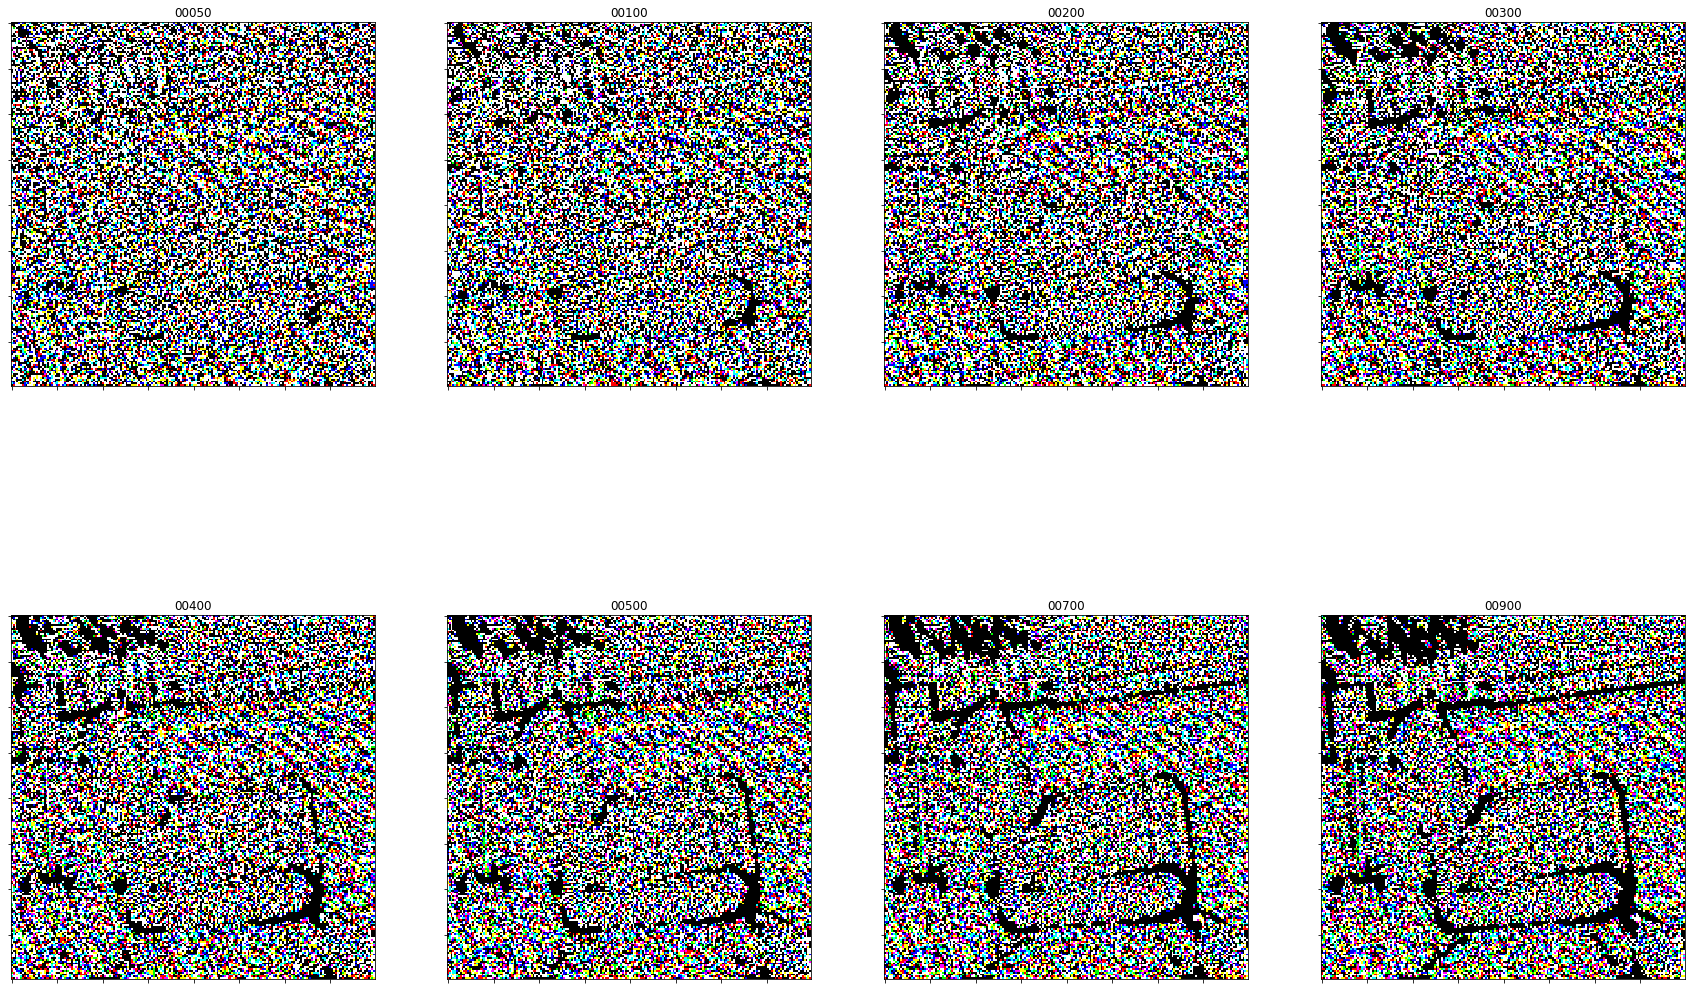

In [65]:
display_zones(dict_appart, zones_mask, 2, 4)

In [86]:
zone_mask_reshape = zones_mask[-1].reshape(3, 200, 200)

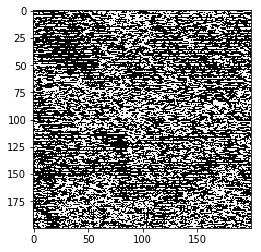

In [87]:
plt.imshow(zone_mask_reshape[0], cmap='gray', vmin=0, vmax=255)

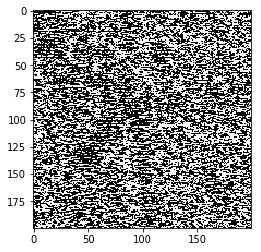

In [88]:
plt.imshow(zone_mask_reshape[1], cmap='gray', vmin=0, vmax=255)

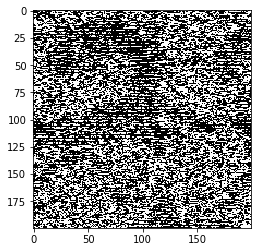

In [89]:
plt.imshow(zone_mask_reshape[2], cmap='gray', vmin=0, vmax=255)